# Text generation

The goal of this project is to demonstrate text generation using LSTM neural networks.
Our database contains numerous movie plots taken from Wikipedia, so we will generate something similiar.

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.models import Sequential
import random 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


In [15]:
data = pd.read_csv("movie_plots.csv")

movie_plots = data['Plot']
print("Max movie plot len: ", movie_plots.map(len).max())
print("Min movie plot len: ", movie_plots.map(len).min())

all_plots = list(movie_plots.values)
# setting a seed so we get the same result every time
random.seed(42)
sample = random.sample(all_plots, 100)
sample[6]

Max movie plot len:  36773
Min movie plot len:  15


'United States Air Force Colonel William Hughes (Paul Kelly) asks Major Paul Peterson (John Payne), who has been called back to active service, to join a team at the Air Research and Development Command conducting tests on a downward ejection seat for bombardiers in the new Boeing B-47 Stratojet bomber. The first tests used articulated dummies, but human test subjects are needed. Besides Colonel Hughes, German scientist Dr. Franz Gruener (Gregory Gaye), also is in charge of the test program, working directly with the test subjects. Captain Jack Nolan (Richard Crane) is also assigned to the project.\r\nThe first volunteer, Captain Mike Cavallero (Eddie Firestone), suffers a broken neck when his parachute opens too early. He survives the test but is hospitalized. The next subject is Lieutenant Edward Simmons, to be followed by Paul. When Mike is suddenly rushed to hospital with an appendicitis attack, Paul moves up. Worried because he has a wife and son, Paul is reluctant to go, but then

## Tokenize words

Tokenization is turning unique words into unique integers. This step is necessary for preparing data for embedding layer.

In [16]:
max_words = 10000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(sample)

sequences = tokenizer.texts_to_sequences(sample)
sequences_len = 200
sequences = pad_sequences(sequences, maxlen = sequences_len, truncating = 'post')
sequences.shape
print(sequences[:2])

[[   9 3264 3265  815  472    7  104  182  815   75   25 1188    2  969
   348 2079    2  530 3266   60  429  815    3 2080  104  116 2081 2082
     5 2083 1513    3    4 2084  599  429    3  116 1189  182 3267   44
   699    1  473 1190   16    1 1514    5   10  531   10 3268  816    2
   182  238   10    3   10 1515  532 3269   53  815 3270 3271   14 1516
   116  128   26    1  430 2085   11  182    3  533   10   30   32    1
  1513   42    8 3272  211  815   52 2086  429  317  248    2 3273    1
    52  970   19    1  348 2080  104  116    3  104    9  600  971  474
   117   63   55  161   59    2  212 3274    9  318    2 2087    1 1517
  2088  382 2089   79  183    2  601   59 3275  182    2  532    9  318
     2 3276    1 3277 2090 1518 1517 2088    9    1  969  348   61  532
    63  972    2  162    4 1519   20   38   43 1191    2  142   62    3
    63   55  383    2  817    1   52  475   15 1192    7 2091   53 2092
    30    7   88  700   42    7 3278  117  971   79  319    3  1

In [17]:
# making a single list of tokens so we can apply sliding windows

text = [item for sublist in sequences for item in sublist]
print("Corpus size: ", len(text))
vocab_size = len(tokenizer.word_index)
print("Vocabulary size: ", vocab_size+1)


Corpus size:  20000
Vocabulary size:  7003


In [18]:
# reverse dictionary so we can decode tokenized sequences back to words
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))


### Splitting the data for input and output values

Input sequence has the size of 20 words, and output is the next word

In [19]:
seq_len = 20

dataX = []
dataY = []

for i in range(len(text)-seq_len):
    seq_in = text[i:i+seq_len]
    seq_out = text[i+seq_len]
    dataX.append(seq_in)
    dataY.append(seq_out)
    
size = len(dataX)
print(size)

19980


In [20]:
dataX = np.asarray(dataX)
dataY = np.asarray(dataY)

print(dataX[0])
print(dataY[0])
print(dataX[1])
print(dataY[1])

print(" ".join(map(lambda x : reverse_word_map[x], dataX[0])))
print(reverse_word_map[dataY[0]])

print(" ".join(map(lambda x : reverse_word_map[x], dataX[1])))
print(reverse_word_map[dataY[1]])

print(" ".join(map(lambda x : reverse_word_map[x], dataX[2])))
print(reverse_word_map[dataY[2]])


[   9 3264 3265  815  472    7  104  182  815   75   25 1188    2  969
  348 2079    2  530 3266   60]
429
[3264 3265  815  472    7  104  182  815   75   25 1188    2  969  348
 2079    2  530 3266   60  429]
815
in 1931 lon rambeau sends his daughter elizabeth rambeau away from london to napa valley california to visit lon's father
philippe
1931 lon rambeau sends his daughter elizabeth rambeau away from london to napa valley california to visit lon's father philippe
rambeau
lon rambeau sends his daughter elizabeth rambeau away from london to napa valley california to visit lon's father philippe rambeau
and


In [21]:
from keras.utils import np_utils

trainX = dataX
trainy = np_utils.to_categorical(dataY)
trainy.shape

(19980, 7003)

### Creating a model

In [24]:
import keras
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Embedding(vocab_size+1, 32, input_length = trainX.shape[1]))
model.add(LSTM(100,  return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(200))
model.add(Dense(trainy.shape[1], activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 32)            224096    
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 100)           53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_2 (Dense)              (None, 7003)              1407603   
Total params: 1,925,699
Trainable params: 1,925,699
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

filepath = "./weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')
callbacks = [checkpoint]

hist = model.fit(trainX, trainy, epochs = 20, batch_size = 128, verbose = 1, callbacks = callbacks, validation_split=0.2)


Train on 15984 samples, validate on 3996 samples
Epoch 1/20
15984/15984 [==============================] - 55s 3ms/step - loss: 6.7313 - acc: 0.2048 - val_loss: 6.4812 - val_acc: 0.2060

Epoch 00001: loss improved from inf to 6.73129, saving model to ./weights.hdf5
Epoch 2/20
15984/15984 [==============================] - 59s 4ms/step - loss: 5.9142 - acc: 0.2065 - val_loss: 6.2300 - val_acc: 0.2060

Epoch 00002: loss improved from 6.73129 to 5.91423, saving model to ./weights.hdf5
Epoch 3/20
15984/15984 [==============================] - 70s 4ms/step - loss: 5.5099 - acc: 0.2225 - val_loss: 6.2400 - val_acc: 0.2417

Epoch 00003: loss improved from 5.91423 to 5.50988, saving model to ./weights.hdf5
Epoch 4/20
15984/15984 [==============================] - 74s 5ms/step - loss: 5.3603 - acc: 0.2406 - val_loss: 6.2069 - val_acc: 0.2490

Epoch 00004: loss improved from 5.50988 to 5.36026, saving model to ./weights.hdf5
Epoch 5/20
15984/15984 [==============================] - 77s 5ms/step

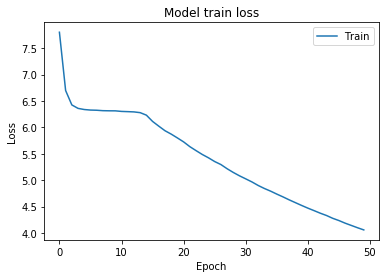

In [66]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
results = model.evaluate(trainX, trainy, batch_size = 128)
print('test loss, test acc:', results)

In [67]:
# Loading weights from a checkpoint

filename = "weights.hdf5"
model.load_weights(filename)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')


In [68]:
def generate_words(seed_text, num_words, model, max_seq_len = 20):
    for i in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen = max_seq_len, padding = 'pre')
        
        predicted = model.predict_classes(token_list, verbose = 0)
        output_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
                
        seed_text = seed_text + " " + output_word
        
    return seed_text.title()

In [69]:
print(generate_words("man in black", 5, model))

Man In Black The Local Village And Old
